<a target="_blank" href="https://colab.research.google.com/github/BonnenLab/U19-preliminary-data-analysis/blob/main/simple-image-stats-mouse.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [21]:
import h5py
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import scipy
import math
import pyrtools as pt
from scipy.signal import fftconvolve
from math import pi
from tqdm import tqdm
import plenoptic

import image_preprocessing as ip

In [22]:
# load the data
f = h5py.File('data/ModelData_070921_J553RT_fm1_dt050_rawWorldCam_4ds.h5', 'r')
# here are the available variables
f.keys()

<KeysViewHDF5 ['model_active', 'model_eyerad', 'model_gz', 'model_nsp', 'model_phi', 'model_pitch', 'model_roll', 'model_speed', 'model_t', 'model_th', 'model_vid_sm', 'model_vid_sm_shift', 'unit_nums']>

Processing frames...



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54353/54353 [00:02<00:00, 24554.10it/s]


Processing frames...



100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54353/54353 [00:02<00:00, 24499.26it/s]


(54353, 30, 30)


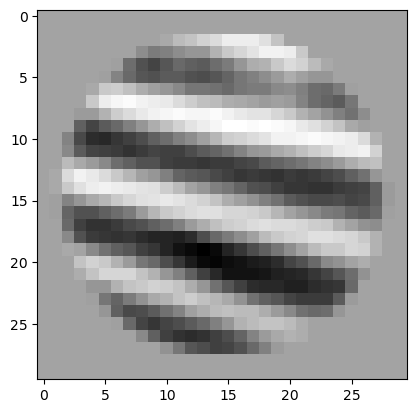

In [23]:



# get both sets of video frames
frames_gaze_centered = f['model_vid_sm_shift'] # Note: the frames seem to range pixel values from -2 to 2.  This is fairly non-standard
frames_gaze_centered = ip.normalize_pixel_intensities(frames_gaze_centered)

frames_head_centered = np.array(f['model_vid_sm'])
frames_head_centered =  ip.normalize_pixel_intensities(frames_head_centered)


# # crop and mask with cosine window
frames_gaze_centered = ip.crop_and_mask_video(frames_gaze_centered)
frames_head_centered = ip.crop_and_mask_video(frames_head_centered)

print(frames_head_centered.shape)
plt.imshow(frames_head_centered[0,:,:],cmap='gray')
plt.show()

## plt.imshow(frames_gaze_centered[0])
plt.colorbar()

frames_gaze_centered.max()

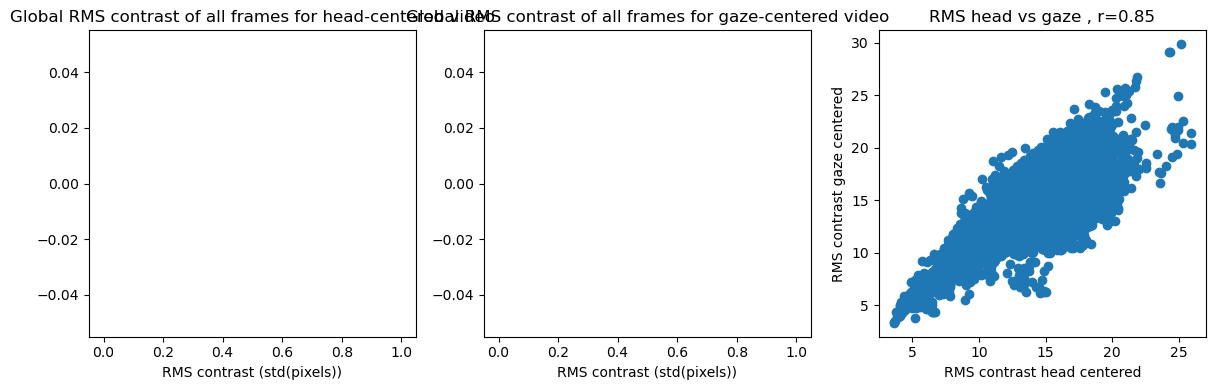

In [4]:
#  Let's try calculating global RMS contrast on all frames
def rms_contrast(img):
    # calculate contrast
    contrast = np.std(img)
    return contrast
    
# Initialize lists to hold RMS contrast values for different types of video frames.
rms_head = []
rms_gaze = []

# Calculate RMS contrasts for head-centered frames.
for frame in frames_head_centered:
    rms_head.append(rms_contrast(frame))

# Calculate RMS contrasts for gaze-centered frames.
for frame in frames_gaze_centered:
    rms_gaze.append(rms_contrast(frame))

# Create a figure with two subplots for dual histograms (1 row, 2 columns).
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Define the bin settings for the histograms.
bins = np.linspace(0, 1, 50)

# Plot histogram for head-centered frames.
axs[0].hist(rms_head, bins)
axs[0].set_xlabel('RMS contrast (std(pixels))')
axs[0].set_title('Global RMS contrast of all frames for head-centered video')

# Plot histogram for gaze-centered frames.
axs[1].hist(rms_gaze, bins)
axs[1].set_xlabel('RMS contrast (std(pixels))')
axs[1].set_title('Global RMS contrast of all frames for gaze-centered video')

axs[2].scatter(rms_head,rms_gaze)
r = np.corrcoef(rms_head,rms_gaze)[0,1]
axs[2].set_title('RMS head vs gaze , r='+ '%.2f' %r)
axs[2].set_xlabel('RMS contrast head centered')
axs[2].set_ylabel('RMS contrast gaze centered')

# Adjust layout and display the plot.
plt.tight_layout()
plt.show()


In [5]:
# Let's do girshick orientation counts.  (04/04/24 -- this takes at least 1 min on a fairly high power macbook pro)
# (see https://www.nature.com/articles/nn.2831 and 
# https://github.com/BonnenLab/image_stats/blob/main/girshick.py)
#
#  TODO: Get Zach's description of these algorithms.
#
#


def girshick_orientation_counts(img,height):
    
    # make filters
    gp = np.array([0.037659, 0.249153, 0.426375, 0.249153, 0.037659])
    gp = gp.reshape((1,5))
    gd = np.array([-0.109604, -0.276691, 0.000000, 0.276691, 0.109604])
    gd = gd.reshape((1,5))
    bfilt = np.array([1, 2, 1])/4
    bfilt = bfilt.reshape(3, 1)

    # get image pyramid
    Gpyr = pt.pyramids.GaussianPyramid(img,height)

    all_hists = [] # list of the 6 histograms for the current frame
    for j in range(height):
        # derivative in x direction
        Ix = pt.pyramids.c.wrapper.corrDn(pt.pyramids.c.wrapper.corrDn(Gpyr.pyr_coeffs[j, 0], gd), gp.T)
        # derivative in y direction
        Iy = pt.pyramids.c.wrapper.corrDn(pt.pyramids.c.wrapper.corrDn(Gpyr.pyr_coeffs[j, 0], gp), gd.T)
    
        Mxx = fftconvolve(fftconvolve(Ix*Ix, bfilt, 'valid'), bfilt.T, 'valid')
        Myy = fftconvolve(fftconvolve(Iy*Iy, bfilt, 'valid'), bfilt.T, 'valid')
        Mxy = fftconvolve(fftconvolve(Ix*Iy, bfilt, 'valid'), bfilt.T, 'valid');
    
        term1   = (Mxx + Myy)/2
        term2   = (term1**2 - (Mxx*Myy - Mxy**2)) ** .5
    
        eps = 2.2204e-16
    
        ev1 = term1 + term2
        ev2 = term1 - term2
        ori = np.arctan2(Mxx-ev2, Mxy)-pi/2
        energy = ev1 + ev2
        orientedness  =  ((ev1-ev2)/(ev1+ev2+eps)) **2

        height, width = orientedness.shape[:2]
        
        # create circle mask to prevent artifacts
        rad = .9*height/2
        x = np.linspace(-width/2, width/2-1, width)
        y = np.linspace(-height/2, height/2-1, height)
        xv, yv = np.meshgrid(x, y)
        ind_central = (xv**2 + yv**2)**.5 > rad
    
        ind1 = energy < max(np.quantile(energy[:],.68), 1e-4)
        ind2 = orientedness < .8
        ori_thresholded = ori
        ori_thresholded[ind1] = np.nan
        ori_thresholded[ind2] = np.nan
        ori_thresholded[ind_central] = np.nan
    
        ori_deg = ori_thresholded.flatten() * (180/pi)
        
        # bin orientations
        h = np.histogram(ori_deg, bins=35,range=(-87.5,87.5))
        
        ind_circ_lower = ori_deg < -87.5
        ind_circ_upper = ori_deg > 87.5 
    
        fs = list(h[0])
        fs.insert(0, np.sum(ori_deg[ind_circ_lower]/ori_deg[ind_circ_lower]) + np.sum(ori_deg[ind_circ_upper]/ori_deg[ind_circ_upper]))
        fs.append(np.sum(ori_deg[ind_circ_lower]/ori_deg[ind_circ_lower]) + np.sum(ori_deg[ind_circ_upper]/ori_deg[ind_circ_upper]))
        fs = np.array(fs)
        all_hists.append(fs)
        
    return all_hists



In [6]:
hists_gaze = []

for ii in tqdm(range(frames_gaze_centered.shape[0])):
    hists = girshick_orientation_counts(frames_gaze_centered[ii],3)
    hists_gaze.append(np.array(hists))

orientation_gaze = np.stack(hists_gaze)


hists_head = []

for ii in tqdm(range(frames_head_centered.shape[0])):
    hists = girshick_orientation_counts(frames_head_centered[ii],3)
    hists_head.append(np.array(hists))

orientation_head = np.stack(hists_head)

  5%|███████▋                                                                                                                                                          | 2576/54353 [00:02<00:56, 918.80it/s]/var/folders/6r/q50gj1mj2012fhzq95rw61w80000gn/T/ipykernel_56162/247854442.py:35: RuntimeWarning: invalid value encountered in sqrt
  term2   = (term1**2 - (Mxx*Myy - Mxy**2)) ** .5
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54353/54353 [01:00<00:00, 896.74it/s]


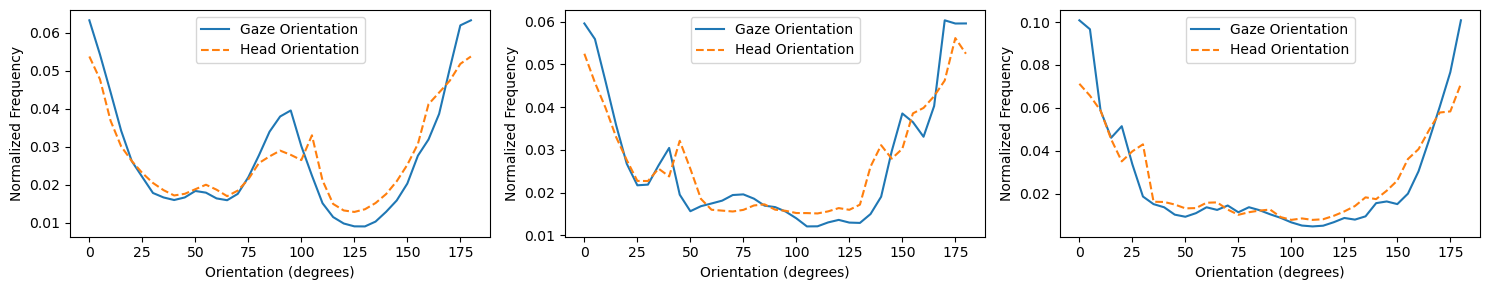

In [7]:
# average orientation statistics at 3 spatial scales for gaze and head orientations
mean_oris = orientation_gaze.mean(axis=0)
mean_head_oris = orientation_head.mean(axis=0)

# Normalizing the frequencies so their sums equal 1 at each spatial scale
norm_mean_oris = mean_oris / mean_oris.sum(axis=1)[:, np.newaxis]
norm_mean_head_oris = mean_head_oris / mean_head_oris.sum(axis=1)[:, np.newaxis]

# Setting up plots to show data at 3 spatial scales for normalized gaze and head orientations
fig, ax = plt.subplots(1, 3, figsize=(15, 3))
x_values = np.linspace(0, 180, 37)  # Orientation angle range from 0 to 180 degrees split into 37 parts
for ii in range(3):
    # Plotting the normalized average gaze orientation
    ax[ii].plot(x_values, norm_mean_oris[ii], label='Gaze Orientation')
    
    # Plotting the normalized average head orientation with a different line style
    ax[ii].plot(x_values, norm_mean_head_oris[ii], label='Head Orientation', linestyle='--')
    ax[ii].set_xlabel('Orientation (degrees)')
    ax[ii].set_ylabel('Normalized Frequency')
    ax[ii].legend()  # Adding a legend to distinguish between the gaze and head orientation plots

plt.tight_layout()  # Adjust layout to prevent overlap of plot elements
plt.show()


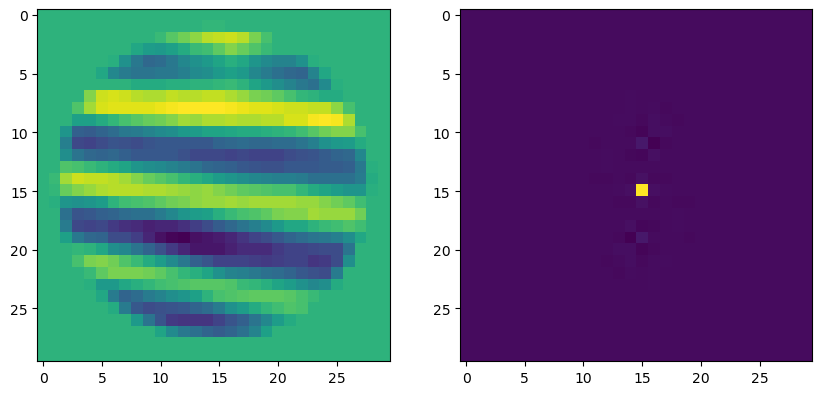

In [14]:
# Example of FFT for a single frame
img= frames_gaze_centered[0]
fft = np.fft.fftshift(np.fft.fft2(img))
fig, ax = plt.subplots(1, 2,figsize=(10,5))

ax[0].imshow(img)
ax[1].imshow(fft.real)

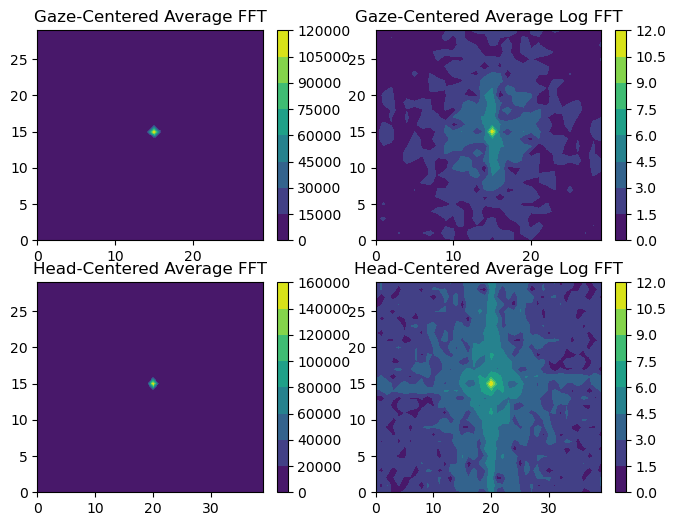

In [15]:
def calculate_mean_fft(frames):
    all_ffts = []
    for img in frames:
        # Optional: Resize image if necessary
        # img = cv2.resize(img, (15, 15), interpolation=cv2.INTER_LINEAR)
        fft = np.fft.fftshift(np.fft.fft2(img))
        all_ffts.append(fft)

    all_ffts = np.stack(all_ffts)
    return all_ffts.mean(axis=0)

# Calculate mean FFT for both gaze-centered and head-centered frames
mean_fft_gaze = calculate_mean_fft(frames_gaze_centered)
mean_fft_head = calculate_mean_fft(frames_head_centered)

# Plotting both sets of FFTs
fig, ax = plt.subplots(2, 2, figsize=(8, 6))

# Visualizing Gaze-Centered FFTs
c = ax[0, 0].contourf(np.abs(mean_fft_gaze.real))
plt.colorbar(c, ax=ax[0, 0])
ax[0, 0].set_title('Gaze-Centered Average FFT')

c = ax[0, 1].contourf(np.log(np.abs(mean_fft_gaze.real) + 1))  # Avoid log(0) errors
plt.colorbar(c, ax=ax[0, 1])
ax[0, 1].set_title('Gaze-Centered Average Log FFT')

# Visualizing Head-Centered FFTs
c = ax[1, 0].contourf(np.abs(mean_fft_head.real))
plt.colorbar(c, ax=ax[1, 0])
ax[1, 0].set_title('Head-Centered Average FFT')

c = ax[1, 1].contourf(np.log(np.abs(mean_fft_head.real) + 1))
plt.colorbar(c, ax=ax[1, 1])
ax[1, 1].set_title('Head-Centered Average Log FFT')

plt.show()

In [16]:
# pyramids...


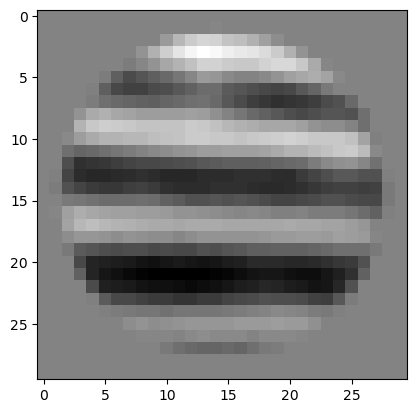

In [18]:
plt.imshow(frames_gaze_centered[1,:,:],cmap='gray')

In [19]:
import cv2
import os
import skvideo.io


def make_video(video_name,frames):

    height, width = frames[0,...].shape
    nFrames = frames.shape[0]
    # encoding = cv2.VideoWriter_fourcc(*'mkv')
    # video = cv2.VideoWriter(video_name, encoding, 25, (width,height),isColor=False)
    # # video = cv2.VideoWriter(video_name, 0, 1, (width,height))

    # for tt in range(nFrames):
    #     video.write(frames[tt,...].astype('uint8'))

    # cv2.destroyAllWindows()
    # video.release()
    writer = skvideo.io.FFmpegWriter(video_name)
    for tt in range(nFrames):
        writer.writeFrame(frames[tt,...].astype('uint8'))

def save_pngs(location,frames):
    for tt in range(2000): # DO NOT GO THROUGH ALL FRAMES (or more than 5k). IT WILL MAKE PROBLEMS WITH YOUR COMPUTER.
        output = frames[tt,...] / 1.0
        cv2.imwrite(os.path.join(location,'frame'+str(tt).zfill(5)+'.png'),output)

# video_name = 'gaze_centered.mp4'
# make_video(video_name,frames_gaze_centered)
# print(frames_gaze_centered.shape)

frames_head_centered = f['model_vid_sm'] 
frames_head_centered = (255*(frames_head_centered[:]/4 + .5)).astype('uint8') # setting image range to [0,1],  from [-2,2]

save_pngs('head_centered_pngs',frames_head_centered)

In [20]:
frames_gaze_centered.shape

(54353, 30, 30)

0 12


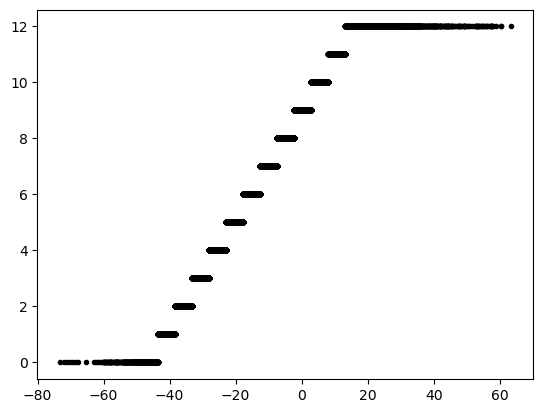

In [158]:
import numpy as np

def assign_to_bins(values, num_bins):
    """
    Assign each value in the array to a bin based on its value.

    Parameters:
    values (array-like): Array of values to be binned.
    num_bins (int): Number of bins to use.

    Returns:
    array: Array indicating the bin each value falls into.
    """
    
    # remove outliers
    z = (values - np.nanmean(values))/np.nanstd(values)
    no_outliers = values[np.abs(z)<2]
    # Compute the bin edges
    bin_edges = np.linspace(1.00001*min(no_outliers), 1.00001*max(no_outliers), num_bins)

    # Assign each value to a bin
    bin_indices = np.digitize(values, bin_edges, right=True)
    
    return bin_indices

# Example usage:
model_pitch = np.array(f['model_pitch'])
num_bins = 12
binned_values = assign_to_bins(model_pitch , num_bins)

plt.plot(model_pitch,binned_values,'k.')

print(binned_values.min(),binned_values.max())

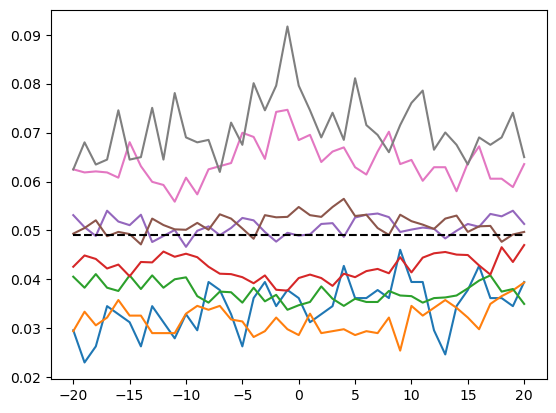

In [173]:
#
def calculate_psth(events,spikes,psth_length):
    """
    Calculate the Peri-Stimulus Time Histogram (PSTH) for a set of spike events.

    Parameters:
    events (np.ndarray): A 1D array of binary events where non-zero values indicate the occurrence of an event.
    spikes (np.ndarray): A 1D array of binary spike data, where each entry represents whether a spike occurred at that time point.
    psth_length (int): The number of time points before and after each event to include in the PSTH.

    Returns:
    np.ndarray: A 1D array representing the average spike response around each event, averaged over all events.
    
    The length of the returned array is `2 * psth_length + 1`.

    Example:
    --------
    >>> events = np.array([0, 1, 0, 0, 1, 0, 0, 0, 1])
    >>> spikes = np.array([0, 1, 0, 1, 0, 1, 0, 1, 0])
    >>> psth_length = 2
    >>> calculate_psth(events, spikes, psth_length)
    array([0.5, 0.5, 0.5, 0.5, 0. ])
    """
    nT = events.shape[0]
    event_times = np.where(events)[0]
    event_times = event_times[(event_times<(nT-psth_length)) & (event_times>(psth_length))]
    response = [spikes[event-psth_length:event+psth_length+1] for event in event_times]
    response = np.stack(response)
    return response.mean(axis=0)

which_neuron = 127
num_bins = 8
psth_length = 20

model_pitch = np.array(f['model_pitch'])
binned_values = assign_to_bins(model_pitch , num_bins)

spikes = np.array(f['model_nsp'])
mean_firing_rates = spikes.mean(axis=0)

for which_bin in range(binned_values.min(),binned_values.max()):
    events = binned_values == which_bin
    psth = calculate_psth(events,spikes[:,which_neuron],psth_length)
    plt.plot(np.arange(-psth_length,psth_length+1),psth)

plt.plot([-psth_length,psth_length],[mean_firing_rates[which_neuron],mean_firing_rates[which_neuron]],'k--')
plt.show()

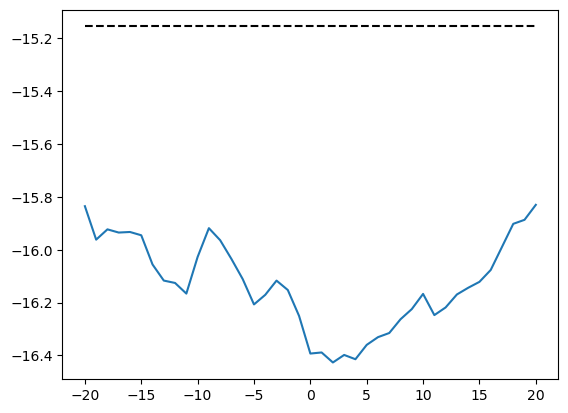

In [224]:
def calculate_spike_triggered_average(spikes,behavior,kernel_length):
    nT = spikes.shape[0]
    spike_times = np.where(spikes>0)[0]
    spike_values = spikes[spikes>0]
    
    spike_times2 = spike_times[(spike_times<(nT-kernel_length)) & (spike_times>(kernel_length))]
    spike_values = spike_values[(spike_times<(nT-kernel_length)) & (spike_times>(kernel_length))]
    
    driving_behavior = [behavior[tt-kernel_length:tt+kernel_length+1] for tt,nspikes in zip(spike_times2,spike_values)]
    driving_behavior= np.stack(driving_behavior)
    return driving_behavior.mean(axis=0)

which_neuron = 40
kernel_length = 20
model_pitch = np.array(f['model_pitch'])
pitch_mu = np.nanmean((model_pitch))
spikes = np.array(f['model_nsp'])
sta = calculate_spike_triggered_average(spikes[:,which_neuron],model_pitch,kernel_length)
plt.plot(np.arange(-kernel_length,kernel_length+1),sta)
plt.plot([-kernel_length,kernel_length],[pitch_mu,pitch_mu],'k--')

# for which_bin in range(binned_values.min(),binned_values.max()):
#     events = binned_values == which_bin
#     psth = calculate_psth(events,spikes[:,which_neuron],psth_length)
#     plt.plot(np.arange(-psth_length,psth_length+1),psth)

# plt.plot([-psth_length,psth_length],[mean_firing_rates[which_neuron],mean_firing_rates[which_neuron]],'k--')
# plt.show()

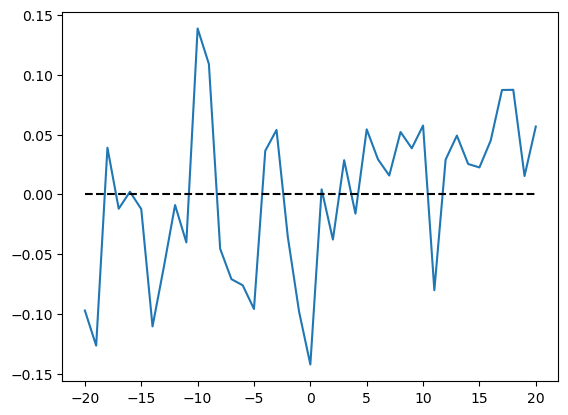

In [225]:
which_neuron = 40
kernel_length = 20
model_pitch = np.array(f['model_pitch'])
pitch_mu = np.nanmean(np.diff(model_pitch))
spikes = np.array(f['model_nsp'])
sta = calculate_spike_triggered_average(spikes[1:,which_neuron],np.diff(model_pitch),kernel_length)
plt.plot(np.arange(-kernel_length,kernel_length+1),sta)
plt.plot([-kernel_length,kernel_length],[pitch_mu,pitch_mu],'k--')
